# Protein Domains
Isotools facilitates integration of functional data on protein isoforms, in the form of protein domains. 

Three different types of sources for protein domains can be used:

* **annotation based**: These domains are based on UniProt UCSC genome browser tracks. Annotation tables can be retrieved from [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables). Select group: = “Genes and Gene Predictions”, track: “UniProt”, and chose from the available tables (e.g. “domains”). Generally, this is the fastest approach, but it does not cover novel exonic regions nor novel splice junctions. These annotations are added to the *Transcriptome* with the method [add_annotation_domains](../isotoolsAPI.html?highlight=add_annotation_domains#isotools.Transcriptome.add_annotation_domains).
* **alignment based**: Second, domain models are aligned to the protein sequences, using hmmer. This depends on model and metadata files for the domains. For Pfam domains, these files are available for download on the interpro website, at "https://www.ebi.ac.uk/interpro/download/Pfam/". Domains are aligned to the transcripts and added to the *Transcriptome* with the method [add_hmmer_domains](../isotoolsAPI.html?highlight=add_hmmer_domains#isotools.Transcriptome.add_hmmer_domains)
* **web request**: Last, domains are obtained with the ebi interpro REST API. This approach is quite slow, and cannot be applied genome wide, and is implemented with the Gene method [add_interpro_domains](../isotoolsAPI.html?highlight=add_interpro_domains#isotools.Gene.add_interpro_domains).

In this tutorial we learn how to use the different resources to functionally annotate the identified transcript isoforms, to depict the domain structure, and to integrate the domain information with differential splicing analysis. 

To run this tutorial, download the transcriptome object file 'PacBio_isotools_substantial_isotools.pkl' from [here](https://nc.molgen.mpg.de/cloud/index.php/s/zYe7g6qnyxGDxRd) to a subfolder 'demonstration_dataset'. Further, the domain resources for annotation based and alignment based domains need to be downloaded, as described above.

In [1]:
from isotools import Transcriptome
import matplotlib.pyplot as plt
import pandas as pd

path='demonstration_dataset'
isoseq=Transcriptome.load(f'{path}/PacBio_isotools_substantial_isotools.pkl')

This is isotools version 0.3.4rc10, but data has been pickled with version 0.3.3, which may be incompatible


## Add annotation based domains.
As described above, annotation tables need to be downloaded [here.](https://genome.ucsc.edu/cgi-bin/hgTables) I downloaded the "Domains", as well as "Transmembrane", and "Interest" annotations as tsv for chr8 in a subfolder "demonstration_dataset/annotation_domains", and named them as follows:

``` bash
> ls demonstration_dataset/annotation_domains/

ucsc_domains.tsv  ucsc_transmembrane.tsv ucsc_interest.tsv
```
The following code adds the annotation from each of the tables in the subfolter 

In [2]:
from pathlib import Path
from glob import glob
for file in glob(f'{path}/annotation_domains/ucsc_*.tsv'):
    what=Path(file).stem.split('_',2)[1]
    print(what)
    isoseq.add_annotation_domains(file,category=what, name_col='name', progress_bar=True)


domains


100%|██████████| 2523/2523 [00:09<00:00, 259.33domains/s]


transmembrane


100%|██████████| 1103/1103 [00:02<00:00, 444.41domains/s]


interest


100%|██████████| 1988/1988 [00:07<00:00, 259.94domains/s]


## Plot the domain structure of genes
IsoTools implements specific visualization functionality to depict the domain structure of genes of interest, to explore different isoforms in the context of protein domains. To this end, *Genes* provide the [plot_domains](../isotoolsAPI.html?highlight=plot_domains#isotools.Transcriptome.plot_domains) method. Here, we want to visualize the top expressed transcripts of the differentially spliced gene RIPK2, which has an exon skipping event between positions 89780160 and 89786592.
While GM12878 exclusively expresses transcripts including the exon, K562 mostly skips this exon. 

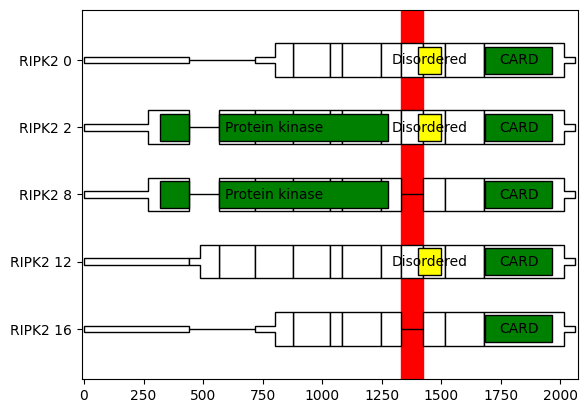

In [3]:
goi=isoseq['RIPK2']
dom_cols={'domains':'green','transmembrane':'pink', 'interest':'yellow'}
es_region=[[89780160, 89786592]] # region to highlight (red vertical stripe)
ax, blocks=goi.plot_domains(source='annotation',
                            categories=['domains','transmembrane', 'interest'], 
                            ref_trids=False, 
                            trids=goi.filter_transcripts('SUBSTANTIAL and not MONO_EXON'), 
                            label='name',
                            domain_cols=dom_cols, 
                            include_utr=True, 
                            max_overlap=3, 
                            highlight=es_region)


As we see, the skipped exon does not disrupt the ORF, and also does not cover a domain, but the disordered region between the Protein kinase and CARD domains.

## Annotate tables with domains

To annotate all identified differential spliced events, we first import the table prepared in the [previous tutorial](09_diff_splice.html). During export, the list format of the transcript id is lost, so we need to make sure they are imported correctly.

In [4]:
import ast

diff_splice=pd.read_csv(f'{path}/demonstration_dataset_differential_events.csv', 
                        converters={col:ast.literal_eval for col in ('trA', 'trB')})


Now, we can use the function [add_domains_to_table](../isotoolsAPI.html?highlight=add_domains_to_table#isotools.domains.add_domains_to_table), to annotate the differential events with the domains. 
This function has a parameter "modes", specifying, how the domains of the event are summarized. 
Domains of transcripts sets from different columns are aggregated with set operations. 
Additionally,  there is a parameter "overlap_only", to consider only domains overlapping the event region (as defined by the "start" end "end" columns of the table).
For example, to get the union of all domains from the transcripts in both sets trA and trB, the "mode" would be "trA|trB". For the top hit, the exon skipping of RIPK2, this reveals the disordered region already identified in the plot above. 
Domains unique to either set can be retrieved with the modes 'trA-trB' and 'trB-trA' respectively, which are evaluated as set differences. 


In [5]:
from isotools.domains import add_domains_to_table

# get domains of the union of sets trA and trB, directly overlapping the event
diff_splice=add_domains_to_table( table=diff_splice, 
                                 transcriptome=isoseq, 
                                 source='annotation',
                                 modes=['trA|trB'], 
                                 overlap_only=True,
                                 naming='name',
                                 insert_after='pvalue' )

# get domains unique to sets trA and trB, from the complete transcript
diff_splice=add_domains_to_table( table=diff_splice, 
                                 transcriptome=isoseq, 
                                 source='annotation',
                                 modes=['trA-trB', 'trB-trA'], 
                                 overlap_only=False,
                                 naming='name',
                                 insert_after='pvalue' )
pd.set_option('display.max_columns', None)
                        
diff_splice[['gene']+[c for c in diff_splice.columns if 'domains' in c]].head()

,gene,trA-trB domains,trB-trA domains,trA|trB overlap domains
0,RIPK2,{},{Disordered},{Disordered}
1,ASAH1,{CBAH},{},{}
2,RECQL4,{},{},{}
3,SNHG6,{},{},{}
4,SMIM19,{},{},{}
